# 신용카드 사기 탐지 모델 만들기

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from datetime import datetime

In [94]:
import sys
print(sys.executable)

C:\Users\Admin\miniforge3\envs\fintech\python.exe


In [3]:
raw_data = pd.read_csv('./data/fraud.csv')
raw_data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   trans_date_trans_time  object 
 1   cc_num                 int64  
 2   merchant               object 
 3   category               object 
 4   amt                    float64
 5   first                  object 
 6   last                   object 
 7   gender                 object 
 8   street                 object 
 9   city                   object 
 10  state                  object 
 11  zip                    int64  
 12  lat                    float64
 13  long                   float64
 14  city_pop               int64  
 15  job                    object 
 16  dob                    object 
 17  trans_num              object 
 18  unix_time              int64  
 19  merch_lat              float64
 20  merch_long             float64
 21  is_fraud               int64  
dtypes: float64(5), int

In [5]:
raw_data.isna().sum()

trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

In [7]:
from ydata_profiling import ProfileReport

C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
profile = ProfileReport(raw_data, title="Profiling Report")
profile.to_file("fraud_eda.html")

Export report to file: 100%|█████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 16.35it/s]


In [33]:
data = raw_data.copy()

In [34]:
data.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [8]:
data[
    data['is_fraud']==1
]

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
2449,2019-01-02 01:06:37,4613314721966,fraud_Rutherford-Mertz,grocery_pos,281.06,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,e8a81877ae9a0a7f883e15cb39dc4022,1325466397,36.430124,-81.179483,1
2472,2019-01-02 01:47:29,340187018810220,"fraud_Jenkins, Hauck and Friesen",gas_transport,11.52,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,bc7d41c41103877b03232f03f1f8d3f5,1325468849,29.819364,-99.142791,1
2523,2019-01-02 03:05:23,340187018810220,fraud_Goodwin-Nitzsche,grocery_pos,276.31,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,b98f12f4168391b2203238813df5aa8c,1325473523,29.273085,-98.836360,1
2546,2019-01-02 03:38:03,4613314721966,fraud_Erdman-Kertzmann,gas_transport,7.03,Jason,Murphy,M,542 Steve Curve Suite 011,Collettsville,...,35.9946,-81.7266,885,Soil scientist,1988-09-15,397894a5c4c02e3c61c784001f0f14e4,1325475483,35.909292,-82.091010,1
2553,2019-01-02 03:55:47,340187018810220,fraud_Koepp-Parker,grocery_pos,275.73,Misty,Hart,F,27954 Hall Mill Suite 575,San Antonio,...,29.4400,-98.4590,1595797,Horticultural consultant,1960-10-28,7863235a750d73a244c07f1fb7f0185a,1325476547,29.786426,-98.683410,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813872,2020-12-22 22:05:48,2242176657877538,"fraud_Willms, Kris and Bergnaum",shopping_pos,1041.51,Travis,Daniel,M,1327 Rose Causeway Apt. 610,Senatobia,...,34.6323,-89.8855,14462,Database administrator,1959-03-03,35b0297dd026d2e9a75d024a5dec7955,1387749948,34.573471,-89.911011,1
1813949,2020-12-22 22:18:07,2242176657877538,fraud_Kuhn LLC,shopping_pos,868.09,Travis,Daniel,M,1327 Rose Causeway Apt. 610,Senatobia,...,34.6323,-89.8855,14462,Database administrator,1959-03-03,da7f67d7375f10a054a3d919448c45dd,1387750687,34.091227,-90.390612,1
1814016,2020-12-22 22:31:48,2242176657877538,"fraud_Mosciski, Ziemann and Farrell",shopping_net,1039.42,Travis,Daniel,M,1327 Rose Causeway Apt. 610,Senatobia,...,34.6323,-89.8855,14462,Database administrator,1959-03-03,25b076c7bcd70f272c1c5326bb234f4b,1387751508,34.628434,-90.284780,1
1814204,2020-12-22 23:06:03,2242176657877538,fraud_Bauch-Raynor,grocery_pos,289.27,Travis,Daniel,M,1327 Rose Causeway Apt. 610,Senatobia,...,34.6323,-89.8855,14462,Database administrator,1959-03-03,2df7d894868fbc99ec1d8b055585fc9d,1387753563,34.746063,-90.401093,1


In [12]:
data[data['is_fraud']==1].groupby('cc_num')['cc_num'].value_counts()

cc_num
60416207185             9
60422928733            12
60423098130            10
60427851591            14
60487002085             8
                       ..
4958589671582726883     7
4973530368125489546    10
4980323467523543940    10
4989847570577635369    15
4992346398065154184     8
Name: count, Length: 976, dtype: int64

In [14]:
data.groupby(['first','last'])['cc_num'].value_counts()

first    last      cc_num             
Aaron    Murray    376028110684021        2920
         Pena      4958589671582726883    2191
         Rogers    4260059589824237        741
         Stewart   4228411452607671        737
Adam     Keller    4917226033950           743
                                          ... 
William  Thompson  4988304376504          2927
Willie   Jordan    213120463918358        1463
Xavier   Beltran   349612764943496        2197
Zachary  Allen     213195754007681        2196
         Boone     374821819075109         735
Name: count, Length: 999, dtype: int64

## 사용자가 어디에 주로 지출했는가?
* 평소 지출하는 카테고리 혹은 가게가 아닌 경우
* ex) 식품에 지출이 많은 사람이 갑자기 레저용품에 지출을 많이 한다
* 카드번호별, 카테고리별 지출 평균, 표준편차

In [109]:
data.groupby(['cc_num','category'])['amt'].agg(['mean','std'])

mean         std
cc_num              category                             
60416207185         entertainment   51.838855   65.485714
                    food_dining     26.737097   46.382603
                    gas_transport   59.779429   15.758267
                    grocery_net     52.152973   17.694871
                    grocery_pos    101.557761   21.894156
...                                       ...         ...
4992346398065154184 misc_pos        60.003043  167.226191
                    personal_care   48.777227   49.523818
                    shopping_net    86.280136  217.047242
                    shopping_pos    64.213333  169.239073
                    travel          70.527193  496.590801

[13171 rows x 2 columns]

In [15]:
def add_datetime_features(df, datetime_col='trans_date_trans_time'):
    """
    주어진 데이터프레임에 datetime 기반 feature를 추가하는 함수.
    
    Parameters:
    - df: pandas DataFrame
    - datetime_col: datetime 컬럼명 (기본값: 'trans_date_trans_time')
    
    Returns:
    - feature가 추가된 DataFrame
    """
    df = df.copy()  # 원본 보호

    # datetime 타입 변환 (혹시 아직 변환 안 되어 있으면)
    df[datetime_col] = pd.to_datetime(df[datetime_col])

    # 파생 feature 생성
    df['year'] = df[datetime_col].dt.year
    df['month'] = df[datetime_col].dt.month
    df['day'] = df[datetime_col].dt.day
    df['hour'] = df[datetime_col].dt.hour
    df['minute'] = df[datetime_col].dt.minute
    df['second'] = df[datetime_col].dt.second
    df['weekday'] = df[datetime_col].dt.weekday  # 0:월요일 ~ 6:일요일
    df['is_weekend'] = df['weekday'].isin([5, 6]).astype(int)

    return df

In [18]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    위도(lat), 경도(lon)로 두 지점 사이 거리(km)를 구하는 함수.
    """
    R = 6371  # 지구 반지름 (단위: km)
    
    # 라디안 변환
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)

    # 차이 계산
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine 공식
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c

    return distance

def add_distance_feature(df, 
                         user_lat_col='lat', user_lon_col='long',
                         merch_lat_col='merch_lat', merch_lon_col='merch_long'):
    """
    고객 위치와 가맹점 위치를 기반으로 거리(km) feature를 추가하는 함수.
    
    Parameters:
    - df: pandas DataFrame
    - user_lat_col, user_lon_col: 고객 위치 컬럼명
    - merch_lat_col, merch_lon_col: 가맹점 위치 컬럼명
    
    Returns:
    - 거리 feature가 추가된 DataFrame
    """
    df = df.copy()
    df['distance_km'] = haversine_distance(
        df[user_lat_col], df[user_lon_col],
        df[merch_lat_col], df[merch_lon_col]
    )
    return df

In [36]:
def replace_birth_with_age(df, birth_col='dob', age_col='age'):
    """
    생년월일 컬럼을 나이(age) 컬럼으로 대체하는 함수.
    """
    df = df.copy()

    # 생년월일을 datetime으로 변환
    df[birth_col] = pd.to_datetime(df[birth_col], errors='coerce')

    # 오늘 날짜
    today = pd.to_datetime(datetime.today().date())

    # 나이 계산
    df[age_col] = today.year - df[birth_col].dt.year

    # 생일이 아직 안 지난 경우 1살 빼기
    not_passed_birthday = ( (df[birth_col].dt.month > today.month) |
                             ((df[birth_col].dt.month == today.month) & (df[birth_col].dt.day > today.day)) )
    df.loc[not_passed_birthday, age_col] -= 1

    # 기존 생년월일 컬럼 삭제
    df = df.drop(columns=[birth_col])

    return df

# 컬럼 처리
* 거래시간
* 고객 및 거래상점 위치

In [38]:
data = add_datetime_features(data)

In [39]:
data = add_distance_feature(data)

In [40]:
data = replace_birth_with_age(data)

In [41]:
data.head(1)

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,year,month,day,hour,minute,second,weekday,is_weekend,distance_km,age
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,2019,1,1,0,0,18,1,0,78.597568,37


# 컬럼 삭제
* 'first', 'last'
* 'trans_date_trans_time', 'unix_time'
* 'street', 'lat', 'long', 'merch_lat','merch_long'
* 'trans_num'

In [43]:
data = data.drop(['first', 'last','trans_date_trans_time', 'unix_time','street', 'lat', 'long', 'merch_lat','merch_long'], axis=1)

In [75]:
data = data.drop('trans_num', axis=1)

In [44]:
data.head(1)

,cc_num,merchant,category,amt,gender,city,state,zip,city_pop,job,...,year,month,day,hour,minute,second,weekday,is_weekend,distance_km,age
0,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,F,Moravian Falls,NC,28654,3495,"Psychologist, counselling",...,2019,1,1,0,0,18,1,0,78.597568,37


# 인코딩
* label encoding : merchant, city, job
* one-hot encoding : category, state, gender

In [45]:
from sklearn.preprocessing import LabelEncoder

In [47]:
def label_encode_columns(df, columns):
    """
    여러 컬럼에 대해 Label Encoding을 적용하는 함수

    Parameters:
    - df: pandas DataFrame
    - columns: 인코딩할 컬럼명 리스트

    Returns:
    - 인코딩된 DataFrame
    - 각 컬럼에 대한 LabelEncoder 객체 딕셔너리 (inverse_transform 할 때 필요)
    """
    df = df.copy()
    encoders = {}

    for col in columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        encoders[col] = le  # 나중에 복원할 수 있도록 저장

    return df, encoders

In [51]:
data, encoders = label_encode_columns(data, ['merchant', 'city', 'job'])

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852394 entries, 0 to 1852393
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   cc_num       int64  
 1   merchant     int64  
 2   category     object 
 3   amt          float64
 4   gender       object 
 5   city         int64  
 6   state        object 
 7   zip          int64  
 8   city_pop     int64  
 9   job          int64  
 10  is_fraud     int64  
 11  year         int32  
 12  month        int32  
 13  day          int32  
 14  hour         int32  
 15  minute       int32  
 16  second       int32  
 17  weekday      int32  
 18  is_weekend   int64  
 19  distance_km  float64
 20  age          int32  
dtypes: float64(2), int32(8), int64(8), object(3)
memory usage: 240.3+ MB


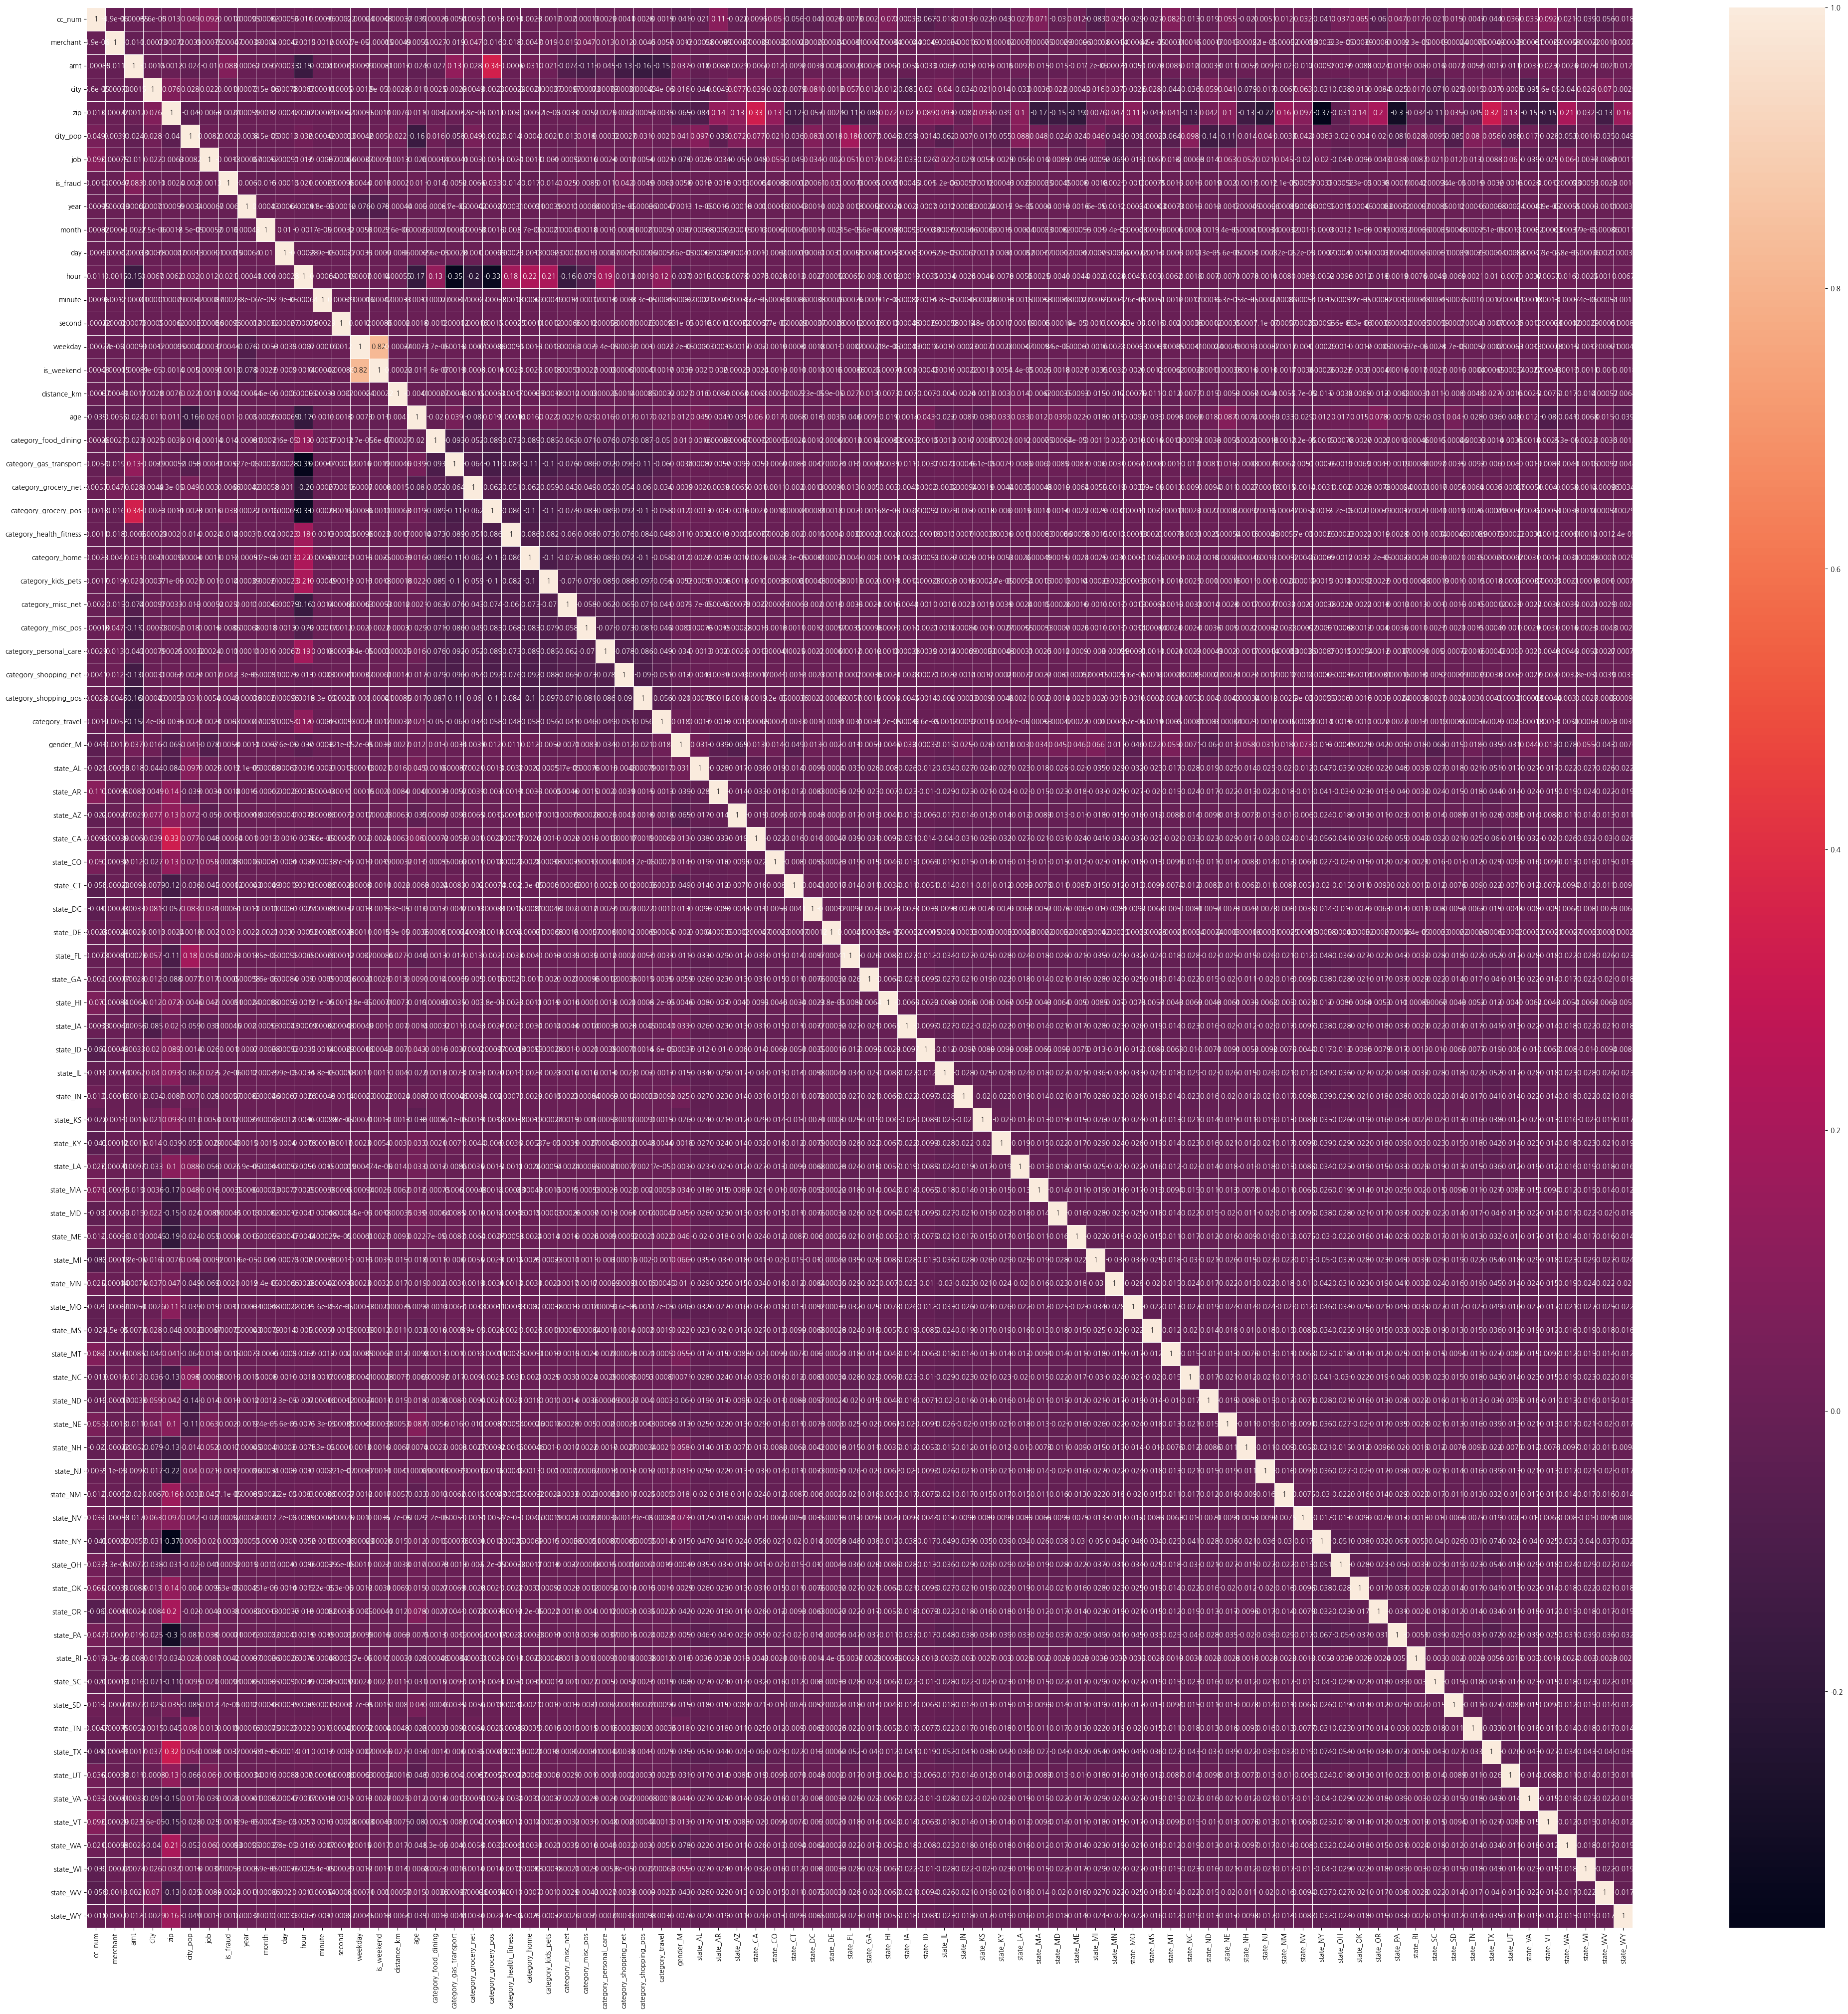

In [102]:
plt.figure(figsize=(50,50))
sns.heatmap(pd.get_dummies(data, drop_first=True).corr(method='spearman'), annot=True, linewidths=0.5)
plt.show()

In [76]:
X = pd.get_dummies(data,columns=['category', 'state', 'gender'], drop_first=True).drop('is_fraud',axis=1)

In [77]:
y = pd.get_dummies(data,columns=['category', 'state', 'gender'], drop_first=True)['is_fraud']

# 홀드아웃

In [67]:
from sklearn.model_selection import train_test_split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# LightGBM

In [84]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

In [96]:
param_grid = {
    'num_leaves': [20, 31, 50, 70],       # 하나의 트리가 가질 수 있는 최대 리프 노드 수 (리프가 많을수록 복잡한 모델, 과적합 주의)
    'max_depth': [5, 7, 10, 15, -1],       # 트리의 최대 깊이 제한 (-1이면 무제한 깊이 허용, 깊을수록 복잡해짐)
    'learning_rate': [0.01, 0.05, 0.1],    # 한 번에 학습하는 정도 (클수록 빠르게 학습하지만 과적합 위험, 작을수록 천천히 안정적으로 학습)
    'n_estimators': [100, 300, 500, 1000], # 트리 개수 (많을수록 성능은 좋아지지만 과적합과 학습시간 증가, learning_rate와 trade-off 관계)
    'subsample': [0.6, 0.8, 1.0],          # 각 트리를 만들 때 사용하는 데이터 비율 (0.8이면 80%만 샘플링, 과적합 방지용)
    'colsample_bytree': [0.6, 0.8, 1.0]    # 하나의 트리를 만들 때 사용하는 feature(컬럼) 비율 (0.8이면 전체 feature 중 80%만 사용, 과적합 방지)
}

model1 = LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)

search = RandomizedSearchCV(
    estimator=model1,
    param_distributions=param_grid,
    n_iter=30,               # 랜덤하게 30개 조합만 뽑아서 시도
    scoring='recall',       # 사기 탐지 성능 지표
    cv=3,                    # 3-fold 교차검증
    verbose=1,
    random_state=42,
#     n_jobs=-1                # 병렬처리 (CPU 다 쓰기)
)

search.fit(X_train, y_train)

print("Best parameters:", search.best_params_)
print("Best AUC Score:", search.best_score_)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best parameters: {'subsample': 0.8, 'num_leaves': 31, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best AUC Score: 0.9734066217133597


In [97]:
lgbm = LGBMClassifier(subsample=0.8, num_leaves=31, n_estimators=100, max_depth=10, learning_rate=0.05, colsample_bytree=1.0, verbose=-1)
lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)
print(classification_report(y_test, pred))
print(roc_auc_score(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    737098
           1       0.92      0.80      0.85      3860

    accuracy                           1.00    740958
   macro avg       0.96      0.90      0.93    740958
weighted avg       1.00      1.00      1.00    740958

0.8987758315388831


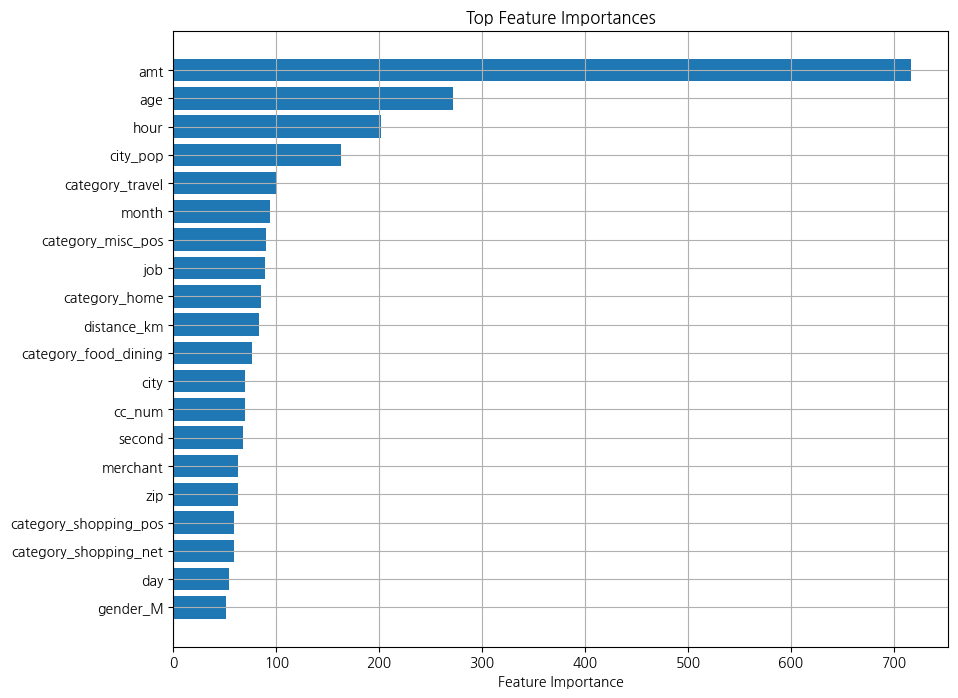

In [103]:
# 1. Feature importance 얻기
importance = lgbm.feature_importances_
feature_names = lgbm.feature_name_

# 2. 중요도 높은 순으로 정렬
indices = np.argsort(importance)[::-1]

# 3. 상위 n개만 보기 (예: 20개)
top_n = 20
top_features = [feature_names[i] for i in indices[:top_n]]
top_importance = importance[indices[:top_n]]

# 4. 시각화
plt.figure(figsize=(10, 8))
plt.barh(top_features[::-1], top_importance[::-1])  # 위에서부터 중요도 높은 순
plt.xlabel('Feature Importance')
plt.title('Top Feature Importances')
plt.grid(True)
plt.show()